In [34]:
import pandas as pd
import numpy as np
import datetime

import random

import seaborn as sn

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

import xgboost as xgb

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [2]:
claims_df = pd.read_csv('Claims1/claims.csv', sep= '|', nrows = 1000000)

members_df = pd.read_csv('Claims1/members.csv', sep= '|', nrows = 1000)

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4,5,6,7,10,11,12,14,16,28,29,30,31,32,33,34,35,57,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
members_df.id.nunique()

1000

In [4]:
claims_df = claims_df.merge(members_df, how = 'left', left_on = 'members_id', right_on = 'id')

In [5]:
#Making prediction data

# claims_df = pd.read_csv('Claims1/claims.csv', sep= '|', nrows = 1000000)

# members_df = pd.read_csv('Claims1/members.csv', sep= '|', nrows = 1000)

# claims_df = claims_df.merge(members_df, how = 'left', left_on = 'members_id', right_on = 'id')

# dat = pd.DataFrame(data = {'members_id': list(set(claims_df.members_id))})

# dat['pot_cd_23'] = random.sample(range(0, dat.shape[0]), dat.shape[0])
# dat['pot_cd_41'] = random.sample(range(0, dat.shape[0]), dat.shape[0])
# dat['pot_cd_81'] = random.sample(range(0, dat.shape[0]), dat.shape[0])
# dat['net_paid_amt_for_rx_claims'] = random.sample(range(0, dat.shape[0]), dat.shape[0])

# dat.to_csv('dummy_prediction_file.csv', index = False)

In [6]:
print(claims_df.shape)
claims_df = claims_df[claims_df['event_date'] <= '2019-01-01T00:00:00Z']
print(claims_df.shape)

(1000000, 98)
(941917, 98)


In [7]:
claims_df['event_date'] = claims_df.event_date.apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ"))

In [8]:
claims_df['event_month'] = claims_df['event_date'].dt.month


In [9]:
claims_df['event_quater'] = pd.cut(claims_df.event_month, [0,3,6,9,12], labels = [1,2,3,4])


In [10]:
claims_df['top_5_pot_cd_23'] = (claims_df.pot_cd == 23)*1
claims_df['top_5_pot_cd_41'] = (claims_df.pot_cd == 41)*1
claims_df['top_5_pot_cd_81'] = (claims_df.pot_cd == 81)*1
claims_df['top_5_net_paid_amt_for_rx_claims'] = claims_df.net_paid_amt[claims_df.event_type == 'rxclaim']

In [11]:
claims_df.head()

,members_id,event_date,serv_to_date,process_date,dateeventcreated,dateeventcompleted,eventdecision,eventdecisiondate,src_platform_cd_x,pymt_cat_cd,bill_type_cd,revenue_cd,line_cat_cd,lclm_rstmt_fin_cat_cd,lclm_rstmt_grp_line_cd,lclm_rstmt_trend_cat_cd,pot_cd,primary_diag_cd,diag_cd2,diag_cd3,diag_cd4,diag_cd5,diag_cd6,diag_cd7,diag_cd8,diag_cd9,hcpcs_cpt4_type_cd1,hcpcs_cpt4_base_cd1,drg_lclm_cd,drg_std_cd,icd_proc_01_cd,icd_proc_02_cd,icd_proc_03_cd,icd_proc_04_cd,icd_proc_05_cd,icd_proc_06_cd,dischg_stat_cd,readmit_orig_ind,readmit_days_cnt,readmit_ind,readmit_drg_match_ind,allow_icob_admit_cnt,allow_icob_days_cnt,allow_icob_visits_cnt,net_paid_amt,line_prov_cd,src_prov_specialty_cd,src_prov_type_cd,src_prov_hosp_phy_cd,std_hipaa_prov_type_cd,std_hipaa_prov_spec_cd,npi_id,event_type,pay_day_supply_cnt,ndc_id,rx_cost,phar_nabp_id,dea_id,mail_order_ind,gpi_cd,claim_generic_ind,copay_amt,brand_name,medclm_lclm_key,id,src_platform_cd_y,smoke_ind,lang_spoken_cd,sold_ledger_nbr,fin_prod_cd,fin_sub_cd,sex_cd,state_cd,cnty_cd,zip_cd,zip_plus_cd,birth_date,age,decsd_date,pre_month_total,group,cons_ccip,cons_chmi,cons_chva,cons_pdpe,cons_cmys,cons_hiri,cons_estdii30,cons_n3039_y,cons_n4049_y,cons_n5059_y,cons_n6064_y,cons_n65p_y,cons_poep_y,cons_hhcomp,cons_estinc30,cons_netw30,cons_homstat,event_month,event_quater,top_5_pot_cd_23,top_5_pot_cd_41,top_5_pot_cd_81,top_5_net_paid_amt_for_rx_claims
0,001e2eaec4cf9a76,2018-04-12,2018-04-12T00:00:00Z,2018-04-19T00:00:00Z,NaN,NaN,NaN,NaN,LV,C,NaN,NaN,4120,PHPC,4120,PH,11,H6120,Z6833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CP,99213,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,False,0.0,False,False,0.0,0.0,1.0,NaN,PC,06,MD,D,193400000X,208D00000X,(other),medclm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,001e2eaec4cf9a76,CP,NaN,SPA,35695.0,MEDR,SND,F,FL,95,(other),(other),1941-01-17T00:00:00Z,78.0,NaN,8.0,ma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,0,0,0,NaN
1,001e2eaec4cf9a76,2018-04-12,2018-04-12T00:00:00Z,2018-04-19T00:00:00Z,NaN,NaN,NaN,NaN,LV,C,131,300,2390,HOHO,2390,HO,22,(other),M722,E7800,Z79899,NaN,NaN,NaN,NaN,NaN,CP,85025,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,False,0.0,False,False,0.0,0.0,1.0,NaN,FB,00,HS,H,282N00000X,282N00000X,(other),medclm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,001e2eaec4cf9a76,CP,NaN,SPA,35695.0,MEDR,SND,F,FL,95,(other),(other),1941-01-17T00:00:00Z,78.0,NaN,8.0,ma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,0,0,0,NaN
2,001e2eaec4cf9a76,2018-04-12,2018-04-12T00:00:00Z,2018-04-19T00:00:00Z,NaN,NaN,NaN,NaN,LV,C,131,300,2390,HOHO,2390,HO,22,(other),M722,E7800,Z79899,NaN,NaN,NaN,NaN,NaN,CP,83036,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,False,0.0,False,False,0.0,0.0,0.0,NaN,FB,00,HS,H,282N00000X,282N00000X,(other),medclm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,001e2eaec4cf9a76,CP,NaN,SPA,35695.0,MEDR,SND,F,FL,95,(other),(other),1941-01-17T00:00:00Z,78.0,NaN,8.0,ma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,0,0,0,NaN
3,001e2eaec4cf9a76,2018-04-12,2018-04-12T00:00:00Z,2018-04-19T00:00:00Z,NaN,NaN,NaN,NaN,LV,C,131,301,2390,HOHO,2390,HO,22,(other),M722,E7800,Z79899,NaN,NaN,NaN,NaN,NaN,CP,83036,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,False,0.0,False,False,0.0,0.0,0.0,NaN,FB,00,HS,H,282N00000X,282N00000X,(other),medclm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,001e2eaec4cf9a76,CP,NaN,SPA,35695.0,MEDR,SND,F,FL,95,(other),(other),1941-01-17T00:00:00Z,78.0,NaN,8.0,ma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,0,0,0,NaN
4,001e2eaec4cf9a76,2018-04-12,2018-04-12T00:00:00Z,2018-04-19T00:00:00Z,NaN,NaN,NaN,NaN,LV,C,131,305,2390,HOHO,2390,HO,22,(other),M722,E7800,Z79899,NaN,NaN,NaN,NaN,NaN,CP,85025,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,False,0.0,False,False,0.0,0.0,0.0,NaN,FB,00,HS,H,282N00000X,282N00000X,(other),medclm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,001e2eaec4cf9a76,CP,NaN,SPA,35695.0,MEDR,SND,F,FL,95,(other),(other),1941-01-17T00:00:00Z,78.0,NaN,8.0,ma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [12]:
# claims_sdf.line_prov_cd.value_counts()
# claims_df.event_type.value_counts()
# claims_df.age.value_counts()

In [13]:

for i in ['line_prov_cd', 'event_type']:
    claims_df = pd.concat([claims_df, pd.get_dummies(claims_df[i]).add_prefix('predictor_' + i + '')], axis = 1)

In [14]:
claims_df.columns

Index(['members_id', 'event_date', 'serv_to_date', 'process_date',
       'dateeventcreated', 'dateeventcompleted', 'eventdecision',
       'eventdecisiondate', 'src_platform_cd_x', 'pymt_cat_cd',
       ...
       'top_5_pot_cd_23', 'top_5_pot_cd_41', 'top_5_pot_cd_81',
       'top_5_net_paid_amt_for_rx_claims', 'predictor_line_prov_cdFB',
       'predictor_line_prov_cdPC', 'predictor_line_prov_cdSP',
       'predictor_event_typemedclm', 'predictor_event_typepahub',
       'predictor_event_typerxclaim'],
      dtype='object', length=110)

In [15]:
feat1 = claims_df.groupby(['members_id', 'event_quater'])[['predictor_line_prov_cdFB',
       'predictor_line_prov_cdPC', 'predictor_line_prov_cdSP',
       'predictor_event_typemedclm', 'predictor_event_typepahub',
       'predictor_event_typerxclaim']].sum().reset_index()

feat1.head()

,members_id,event_quater,predictor_line_prov_cdFB,predictor_line_prov_cdPC,predictor_line_prov_cdSP,predictor_event_typemedclm,predictor_event_typepahub,predictor_event_typerxclaim
0,0004e941e8d0fabd,1,NaN,NaN,NaN,NaN,NaN,NaN
1,0004e941e8d0fabd,2,0.0,0.0,0.0,0.0,0.0,2.0
2,0004e941e8d0fabd,3,NaN,NaN,NaN,NaN,NaN,NaN
3,0004e941e8d0fabd,4,0.0,1.0,0.0,1.0,0.0,5.0
4,00070b4b06f86778,1,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
feat2 = claims_df.groupby(['members_id'])['age'].mean().reset_index()


In [17]:
temp_df = claims_df.groupby(['members_id', 'event_quater'])['top_5_pot_cd_23', 
                                                  'top_5_pot_cd_41', 
                                                  'top_5_pot_cd_81', 
                                                  'top_5_net_paid_amt_for_rx_claims'].sum().reset_index()



# gby.top_5_pot_cd_23.sum().reset_index(drop = True).describe()
#     'top_5_pot_cd_23': ['sum', 'max']}).reset_index()

In [18]:
temp_df.head()

,members_id,event_quater,top_5_pot_cd_23,top_5_pot_cd_41,top_5_pot_cd_81,top_5_net_paid_amt_for_rx_claims
0,0004e941e8d0fabd,1,NaN,NaN,NaN,NaN
1,0004e941e8d0fabd,2,0.0,0.0,0.0,26.9
2,0004e941e8d0fabd,3,NaN,NaN,NaN,NaN
3,0004e941e8d0fabd,4,0.0,0.0,0.0,0.0
4,00070b4b06f86778,1,NaN,NaN,NaN,NaN


In [19]:
temp_df

,members_id,event_quater,top_5_pot_cd_23,top_5_pot_cd_41,top_5_pot_cd_81,top_5_net_paid_amt_for_rx_claims
0,0004e941e8d0fabd,1,NaN,NaN,NaN,NaN
1,0004e941e8d0fabd,2,0.0,0.0,0.0,26.90
2,0004e941e8d0fabd,3,NaN,NaN,NaN,NaN
3,0004e941e8d0fabd,4,0.0,0.0,0.0,0.00
4,00070b4b06f86778,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
59615,ffee1992ecc4ff15,4,0.0,0.0,0.0,78.97
59616,fffa08338acb8e3f,1,0.0,0.0,0.0,405.14
59617,fffa08338acb8e3f,2,0.0,0.0,0.0,868.65
59618,fffa08338acb8e3f,3,0.0,0.0,0.0,1060.62


In [20]:
lead_temp_df = temp_df.groupby(['members_id'])['top_5_pot_cd_23', 
                                                  'top_5_pot_cd_41', 
                                                  'top_5_pot_cd_81', 
                                                  'top_5_net_paid_amt_for_rx_claims'].shift(1).reset_index()


temp_df.rename(columns={"top_5_pot_cd_23": "predictors_quaterly_sums_top_5_pot_cd_23", 
                 "top_5_pot_cd_41": "predictors_quaterly_sums_top_5_pot_cd_41", 
                 "top_5_pot_cd_81": "predictors_quaterly_sums_top_5_pot_cd_81",
                 "top_5_net_paid_amt_for_rx_claims": "predictors_quaterly_sums_top_5_net_paid_amt_for_rx_claims"}, inplace = True)


In [21]:
lead_temp_df.drop('index', inplace = True, axis = 1)

lead_temp_df.head()

,top_5_pot_cd_23,top_5_pot_cd_41,top_5_pot_cd_81,top_5_net_paid_amt_for_rx_claims
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,26.9
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN


In [22]:
final_data = pd.concat([temp_df, lead_temp_df], axis = 1)
# final_data.drop('index', inplace = True)
final_data = final_data[final_data.event_quater > 1]

final_data = final_data.reset_index(drop = True)

In [23]:
final_data.head(20)

,members_id,event_quater,predictors_quaterly_sums_top_5_pot_cd_23,predictors_quaterly_sums_top_5_pot_cd_41,predictors_quaterly_sums_top_5_pot_cd_81,predictors_quaterly_sums_top_5_net_paid_amt_for_rx_claims,top_5_pot_cd_23,top_5_pot_cd_41,top_5_pot_cd_81,top_5_net_paid_amt_for_rx_claims
0,0004e941e8d0fabd,2,0.0,0.0,0.0,26.90,NaN,NaN,NaN,NaN
1,0004e941e8d0fabd,3,NaN,NaN,NaN,NaN,0.0,0.0,0.0,26.90
2,0004e941e8d0fabd,4,0.0,0.0,0.0,0.00,NaN,NaN,NaN,NaN
3,00070b4b06f86778,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00070b4b06f86778,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,00070b4b06f86778,4,0.0,0.0,0.0,0.00,NaN,NaN,NaN,NaN
6,0013b61b31044017,2,0.0,0.0,0.0,0.00,40.0,2.0,0.0,3.00
7,0013b61b31044017,3,0.0,0.0,0.0,11.30,0.0,0.0,0.0,0.00
8,0013b61b31044017,4,0.0,0.0,0.0,27.60,0.0,0.0,0.0,11.30
9,00150cf098b44436,2,0.0,0.0,0.0,0.00,0.0,0.0,3.0,0.00


In [24]:
final_data = final_data.merge(feat1, on = ['members_id', 'event_quater'], how = 'left')
final_data = final_data.merge(feat2, on = 'members_id', how = 'left')


In [ ]:
# 1. ER Visits--> pot_cd--> 23
# 2.Land Ambulance --> pot_cd-->41
# 3. LAB --> pot_cd-->81
# 4.Rx Claims--> event_type==‘rxclaim’--> Net Amt/Total RX Claims

In [25]:
final_data.event_quater.value_counts()

4    14905
3    14905
2    14905
1        0
Name: event_quater, dtype: int64

In [29]:
train = final_data[final_data.event_quater != 4]
test = final_data[final_data.event_quater == 4]


In [30]:
train.event_quater.value_counts()

3    14905
2    14905
4        0
1        0
Name: event_quater, dtype: int64

In [31]:
test.event_quater.value_counts()

4    14905
3        0
2        0
1        0
Name: event_quater, dtype: int64

In [32]:
train.head()

,members_id,event_quater,predictors_quaterly_sums_top_5_pot_cd_23,predictors_quaterly_sums_top_5_pot_cd_41,predictors_quaterly_sums_top_5_pot_cd_81,predictors_quaterly_sums_top_5_net_paid_amt_for_rx_claims,top_5_pot_cd_23,top_5_pot_cd_41,top_5_pot_cd_81,top_5_net_paid_amt_for_rx_claims,predictor_line_prov_cdFB,predictor_line_prov_cdPC,predictor_line_prov_cdSP,predictor_event_typemedclm,predictor_event_typepahub,predictor_event_typerxclaim,age
0,0004e941e8d0fabd,2,0.0,0.0,0.0,26.9,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,2.0,NaN
1,0004e941e8d0fabd,3,NaN,NaN,NaN,NaN,0.0,0.0,0.0,26.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00070b4b06f86778,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00070b4b06f86778,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0013b61b31044017,2,0.0,0.0,0.0,0.0,40.0,2.0,0.0,3.0,0.0,0.0,28.0,28.0,0.0,0.0,NaN


In [35]:
train.columns

Index(['members_id', 'event_quater',
       'predictors_quaterly_sums_top_5_pot_cd_23',
       'predictors_quaterly_sums_top_5_pot_cd_41',
       'predictors_quaterly_sums_top_5_pot_cd_81',
       'predictors_quaterly_sums_top_5_net_paid_amt_for_rx_claims',
       'top_5_pot_cd_23', 'top_5_pot_cd_41', 'top_5_pot_cd_81',
       'top_5_net_paid_amt_for_rx_claims', 'predictor_line_prov_cdFB',
       'predictor_line_prov_cdPC', 'predictor_line_prov_cdSP',
       'predictor_event_typemedclm', 'predictor_event_typepahub',
       'predictor_event_typerxclaim', 'age'],
      dtype='object')

In [36]:
predictors = ['predictors_quaterly_sums_top_5_pot_cd_23',
       'predictors_quaterly_sums_top_5_pot_cd_41',
       'predictors_quaterly_sums_top_5_pot_cd_81',
       'predictors_quaterly_sums_top_5_net_paid_amt_for_rx_claims',
       'predictor_line_prov_cdFB',
       'predictor_line_prov_cdPC', 'predictor_line_prov_cdSP',
       'predictor_event_typemedclm', 'predictor_event_typepahub',
       'predictor_event_typerxclaim', 'age']

CV Error for:top_5_pot_cd_23
[0]	train-rmse:9.04703+0.0630177	test-rmse:9.05694+0.254058
[1]	train-rmse:9.01648+0.0626166	test-rmse:9.03654+0.252282
[2]	train-rmse:8.98815+0.0658193	test-rmse:9.02059+0.251122
[3]	train-rmse:8.96196+0.0667856	test-rmse:9.00825+0.250574
[4]	train-rmse:8.93964+0.0660699	test-rmse:8.99778+0.250686
[5]	train-rmse:8.91702+0.0657261	test-rmse:8.98954+0.250327
[6]	train-rmse:8.89914+0.0632944	test-rmse:8.98243+0.249769
[7]	train-rmse:8.87989+0.061811	test-rmse:8.97735+0.249646
[8]	train-rmse:8.86188+0.0589343	test-rmse:8.97418+0.25001
[9]	train-rmse:8.84657+0.0583208	test-rmse:8.9701+0.249512
[10]	train-rmse:8.83281+0.0562501	test-rmse:8.9677+0.249252
[11]	train-rmse:8.81787+0.057494	test-rmse:8.96693+0.249855
[12]	train-rmse:8.80277+0.0569139	test-rmse:8.96659+0.249685
[13]	train-rmse:8.79197+0.0543044	test-rmse:8.96604+0.250067
[14]	train-rmse:8.77905+0.0539039	test-rmse:8.96659+0.249907
[15]	train-rmse:8.76877+0.0531392	test-rmse:8.9664+0.250279
[16]	train-

[39]	train-rmse:850.811+8.80394	test-rmse:1037.91+32.6949
[40]	train-rmse:848.071+8.2934	test-rmse:1037.79+33.1682
[41]	train-rmse:846.512+8.00164	test-rmse:1037.89+33.1577
[42]	train-rmse:842.922+7.96799	test-rmse:1038.43+32.717
[43]	train-rmse:840.903+7.86666	test-rmse:1038.99+32.1057
[44]	train-rmse:839.021+8.23134	test-rmse:1039.63+32.2944
[45]	train-rmse:836.718+8.22352	test-rmse:1040.45+32.6197
[46]	train-rmse:834.7+9.03904	test-rmse:1041.72+32.5031


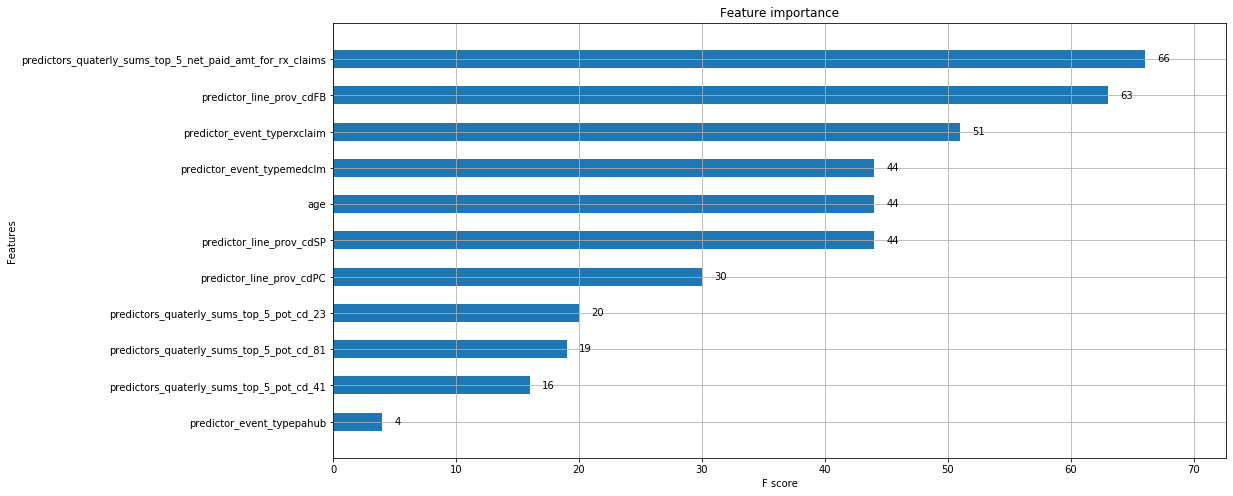

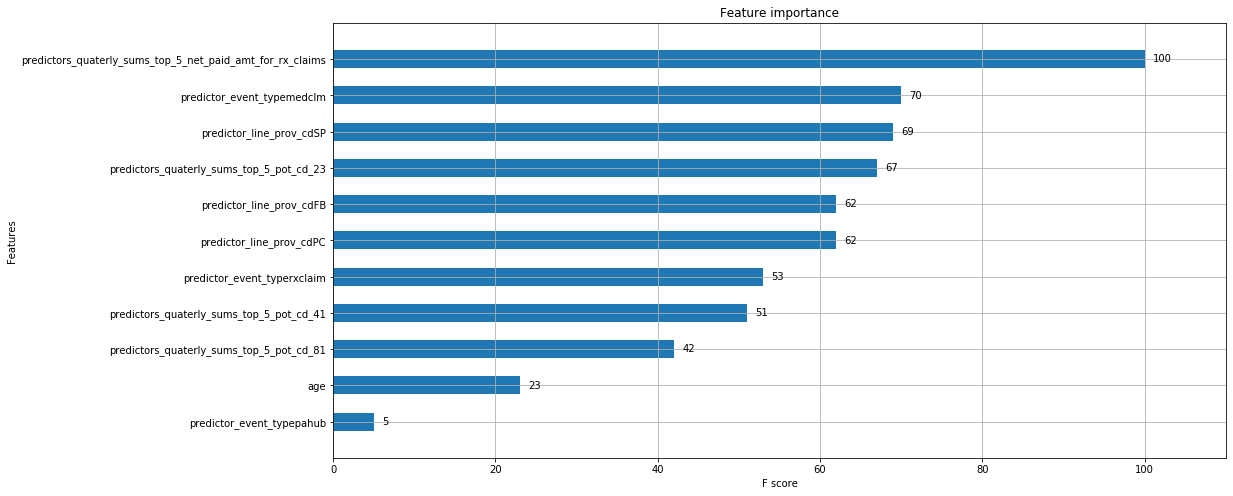

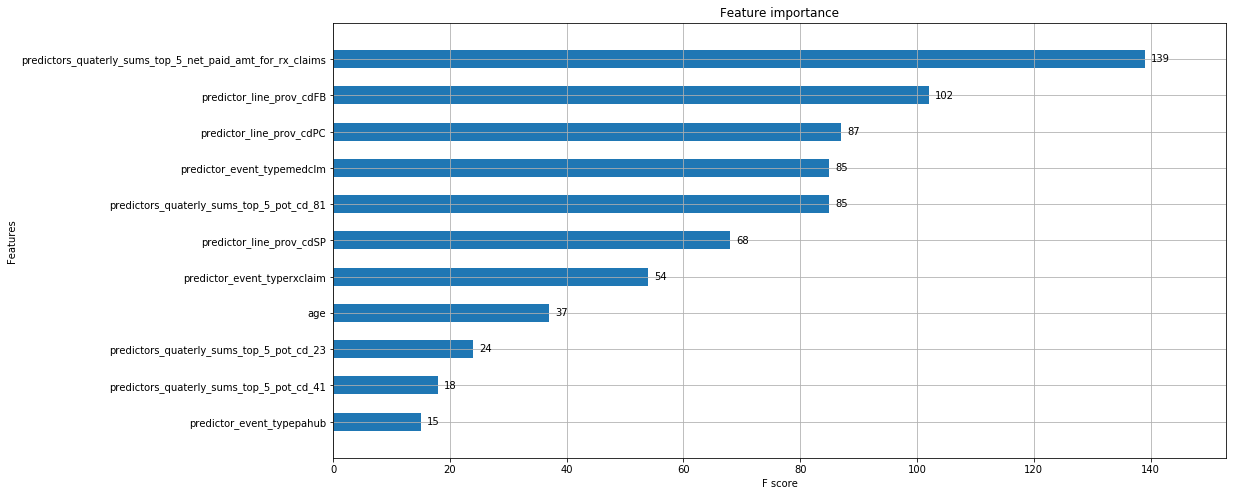

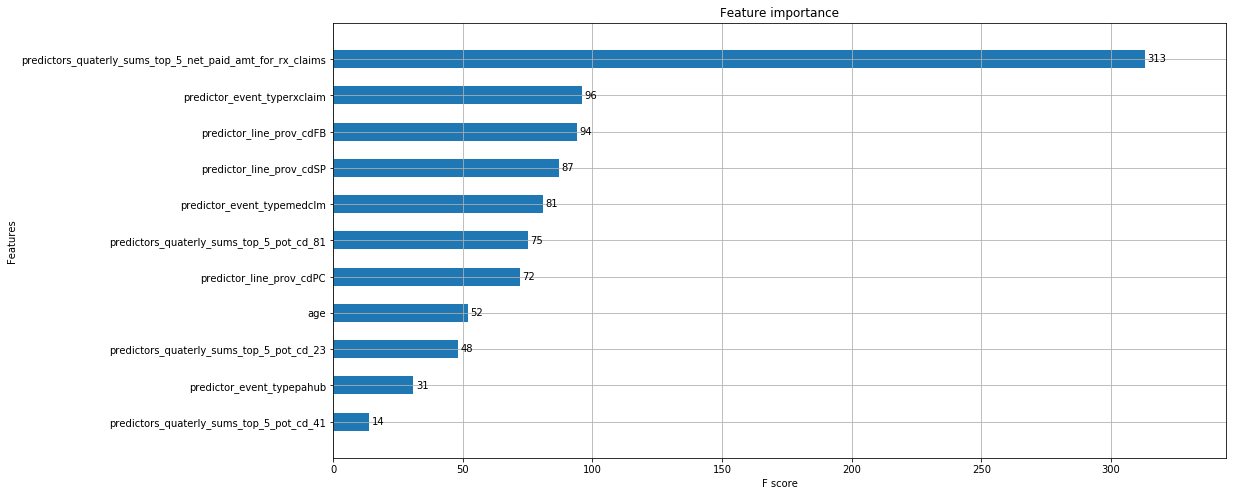

In [90]:

outcomes = ['top_5_pot_cd_23', 'top_5_pot_cd_41', 'top_5_pot_cd_81', 'top_5_net_paid_amt_for_rx_claims']

for o in outcomes:
    
    n_folds = 5
    early_stopping = 10
    params = {'eta': 0.1, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'objective': 'reg:squarederror', 'seed': 99, 'silent': 0, 'eval_metric':'rmse', 'nthread':4}

    print("CV Error for:" + str(o))
    if(o == 'top_5_pot_cd_23'):
        xg_train = xgb.DMatrix(train[predictors], label=train[o].fillna(0))
        cv = xgb.cv(params, xg_train, 5000, nfold=n_folds, early_stopping_rounds=early_stopping, verbose_eval=1)
        model_top_5_pot_cd_23 = xgb.train(params, xg_train, len(cv), verbose_eval=1)
        fig, ax = plt.subplots(1, 1, figsize=(16, 8))
        xgb.plot_importance(model_top_5_pot_cd_23, height=0.5, ax=ax)
    elif(o == 'top_5_pot_cd_41'):
        xg_train = xgb.DMatrix(train[predictors], label=train[o].fillna(0))
        cv = xgb.cv(params, xg_train, 5000, nfold=n_folds, early_stopping_rounds=early_stopping, verbose_eval=1)
        model_top_5_pot_cd_41 = xgb.train(params, xg_train, len(cv), verbose_eval=1)
        fig, ax = plt.subplots(1, 1, figsize=(16, 8))
        xgb.plot_importance(model_top_5_pot_cd_41, height=0.5, ax=ax)
    elif(o == 'top_5_pot_cd_81'):
        xg_train = xgb.DMatrix(train[predictors], label=train[o].fillna(0))
        cv = xgb.cv(params, xg_train, 5000, nfold=n_folds, early_stopping_rounds=early_stopping, verbose_eval=1)
        model_top_5_pot_cd_81 = xgb.train(params, xg_train, len(cv), verbose_eval=1)
        fig, ax = plt.subplots(1, 1, figsize=(16, 8))
        xgb.plot_importance(model_top_5_pot_cd_81, height=0.5, ax=ax)
    elif(o == 'top_5_net_paid_amt_for_rx_claims'):
        xg_train = xgb.DMatrix(train[predictors], label=train[o].fillna(0))
        cv = xgb.cv(params, xg_train, 5000, nfold=n_folds, early_stopping_rounds=early_stopping, verbose_eval=1)
        model_top_5_net_paid_amt_for_rx_claims = xgb.train(params, xg_train, len(cv), verbose_eval=1)
        fig, ax = plt.subplots(1, 1, figsize=(16, 8))
        xgb.plot_importance(model_top_5_net_paid_amt_for_rx_claims, height=0.5, ax=ax)
    

In [91]:

outcomes = ['top_5_pot_cd_23', 'top_5_pot_cd_41', 'top_5_pot_cd_81', 'top_5_net_paid_amt_for_rx_claims']

predicted_df = test[['members_id']]

for o in outcomes:
    
    xg_test = xgb.DMatrix(test[predictors])
    
    if(o == 'top_5_pot_cd_23'):
        predicted_df['pot_cd_23'] = model_top_5_pot_cd_23.predict(xg_test)
    elif(o == 'top_5_pot_cd_41'):
        predicted_df['pot_cd_41'] = model_top_5_pot_cd_41.predict(xg_test)
    elif(o == 'top_5_pot_cd_81'):
        predicted_df['pot_cd_81'] = model_top_5_pot_cd_81.predict(xg_test)
    elif(o == 'top_5_net_paid_amt_for_rx_claims'):
        predicted_df['net_paid_amt_for_rx_claims'] = model_top_5_net_paid_amt_for_rx_claims.predict(xg_test)
    

In [92]:
predicted_df.describe()

,pot_cd_23,pot_cd_41,pot_cd_81,net_paid_amt_for_rx_claims
count,14905.000000,14905.000000,14905.000000,14905.000000
mean,1.422934,0.078349,1.496761,269.844543
std,0.784610,0.053047,0.835133,491.848114
min,0.558839,0.006568,0.412549,-88.911331
25%,0.924201,0.053119,0.911991,58.204369
50%,1.270550,0.067633,1.373514,135.599182
75%,1.620543,0.080717,1.777257,258.976227
max,12.581582,2.276876,13.361413,14719.577148


In [93]:
predicted_df.to_csv("predicted_df.csv", index = False)